In [1]:
import random
import torch
import os
import glob
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import timm
import tensorflow

from torch.utils.data import Dataset
from PIL import Image
from PIL import ImageFilter
from torch.utils.data import DataLoader
from custom_dataset import custom_dataset
from torchvision import models
from timm.loss import LabelSmoothingCrossEntropy

from custom_dataset import *

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [9]:
torch.__version__

'1.13.1+cpu'

In [11]:
tensorflow.__version__

'2.10.1'

In [8]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cpu')

In [3]:
class custom_dataset(Dataset) :

    def __init__(self, file_path):
        # file_path -> data/train   /0/*.png
        self.file_path = glob.glob(os.path.join(file_path,"*","*.png" ))
        self.transform = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor()
        ])
    def __getitem__(self, item):

        image_path = self.file_path[item]
        label = image_path.split("\\")
        # print(label)
        label = int(label[1])

        mo =  image_path.split("\\")
        mo = mo[0]

        img = Image.open(image_path).convert('RGB')

        if mo == "data/train" :
            pass
            if random.uniform(0,1) < 0.2 or img.getbands()[0] == 'L' :
                # Random gray scale from 20%
                img = img.convert('L').convert("RGB")

            if random.uniform(0,1) < 0.2 :
                # Rnadom Gaussian blur from 20%
                gaussianBlur = ImageFilter.GaussianBlur(random.uniform(0.5, 1.2))
                img = img.filter(gaussianBlur)

        else :
            if img.getbands()[0] == 'L' :
                img = img.convert('L').convert('RGB')
        img = self.transform(img)
        # print(img.size(), image_path)

        return img, label

    def __len__(self):
        return  len(self.file_path)

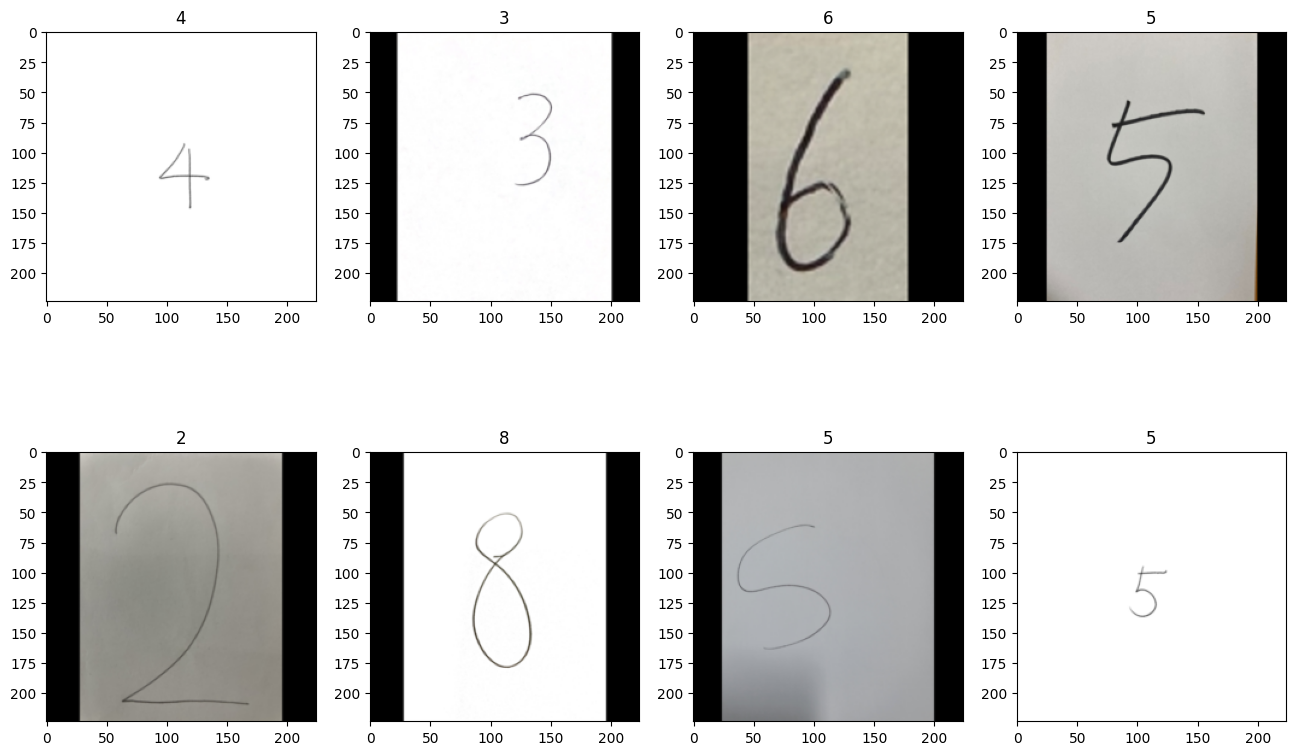

In [4]:
train_dataset = custom_dataset("./data/train")
for i in train_dataset :
    pass

# print(train_dataset.__len__())

_ , ax = plt.subplots(2,4,figsize=(16,10))

for i in range(8) :
    data = train_dataset.__getitem__(np.random.choice(range(train_dataset.__len__())))

    image = data[0].cpu().detach().numpy().transpose(1,2,0) * 255
    image = image.astype(np.uint32)

    label = data[1]

    ax[i//4][i-(i//4)*4].imshow(image)
    ax[i//4][i-(i//4)*4].set_title(label)

plt.show()

In [5]:
# dataset
train_data = custom_dataset("./data/train")
test_data  = custom_dataset("./data/train")

# dataloader
train_loader = DataLoader(train_data,batch_size=12, shuffle=True)
test_loader = DataLoader(test_data, batch_size=12, shuffle=False)

In [6]:
# model call
net = models.__dict__["resnet18"](pretrained=True)
net.fc = nn.Linear(512,10)
net.to(device)

# loss function
criterion = LabelSmoothingCrossEntropy()
criterion = criterion.to(device) # this is better than nn.CrossEntropyLoss
# optimizer
optimizer = torch.optim.AdamW(net.parameters(), lr=0.001)

c:\Users\tempe\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\tempe\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
net.train()
total_step = len(train_loader)
curr_lr = 0.001
best_score = 0
num_epochs = 100
for epoch in range(num_epochs + 1) :
    total_loss = 0
    for i,(images, labels) in enumerate(train_loader) :
        images = images.to(device)
        labels = labels.to(device)
        output = net(images)
        loss = criterion(output, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if (i+1) % 100 == 0 :
            print("{} / {}".format(12*(i+1), train_data.__len__()))

    net.eval()
    score = 0
    total = 0
    for i,(images, labels) in enumerate(test_loader) :
        images = images.to(device)
        labels = labels.to(device)
        output = net(images)

        total += images.size(0)
        _, argmax = torch.max(output, 1)
        score += (labels == argmax).sum().item()
    print("Epoch : {}, Loss : {:.4f}".format(
        epoch+1, total_loss / total_step
    ))

    avg = (score / total * 100)
    print("Accuracy : {:.2f}\n".format(avg))
    net.train()

    if best_score < avg :
        best_score = avg
        torch.save(net.state_dict(), "./best.pt")

Epoch : 1, Loss : 1.4389
Accuracy : 79.44

Epoch : 2, Loss : 0.8420
Accuracy : 82.95

Epoch : 3, Loss : 0.7448
Accuracy : 92.44

Epoch : 4, Loss : 0.6948
Accuracy : 90.86

Epoch : 5, Loss : 0.6413
Accuracy : 99.65

Epoch : 6, Loss : 0.5727
Accuracy : 99.82

Epoch : 7, Loss : 0.5618
Accuracy : 100.00

Epoch : 8, Loss : 0.5559
Accuracy : 100.00

